In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import glob as gb
import os

import h5py
import numpy as np
from PIL import Image
from tqdm import tqdm


# normalization x to [-1,1]
def normalization(x):
    return x / 127.5 - 1


# according the image path to read the image and covert it
# to the given size, then slice it, finally return the full and blur images
def format_image(image_path, size):
    image = Image.open(image_path)
    # slice image into full and blur images
    image_full = image.crop((0, 0, image.size[0] / 2, image.size[1]))
    # Note the full image in left, the blur image in right
    image_blur = image.crop((image.size[0] / 2, 0, image.size[0], image.size[1]))

    # image_full.show()
    # image_blur.show()

    image_full = image_full.resize((size, size), Image.ANTIALIAS)
    image_blur = image_blur.resize((size, size), Image.ANTIALIAS)

    # return the numpy arrays
    return np.array(image_full), np.array(image_blur)


# convert images to hdf5 data
def build_hdf5(jpeg_dir, size=256):
    # put data in HDF5
    hdf5_file = os.path.join('/content/gdrive/My Drive/data (1)', 'data.h5')
    with h5py.File(hdf5_file, 'w') as f:

        for data_type in tqdm(['train', 'test'], desc='create HDF5 dataset from images'):
            data_path = jpeg_dir + '/%s/*.jpg' % data_type
            images_path = gb.glob(data_path)
            # print(images_path)
            data_full = []
            data_blur = []
            for image_path in images_path:
                image_full, image_blur = format_image(image_path, size)
                data_full.append(image_full)
                data_blur.append(image_blur)

            # print(len(data_full))
            # print(len(data_blur))
            f.create_dataset('%s_data_full' % data_type, data=data_full)
            f.create_dataset('%s_data_blur' % data_type, data=data_blur)


# load data by data type
def load_data(data_type):
    with h5py.File('/content/gdrive/My Drive/data (1)/data.h5', 'r') as f:
        data_full = f['%s_data_full' % data_type][:].astype(np.float32)
        data_full = normalization(data_full)

        data_blur = f['%s_data_blur' % data_type][:].astype(np.float32)
        data_blur = normalization(data_blur)

        return data_full, data_blur


def generate_image(full, blur, generated, path, epoch=None, index=None):
    full = full * 127.5 + 127.5
    blur = blur * 127.5 + 127.5
    generated = generated * 127.5 + 127.5
    for i in range(generated.shape[0]):
        image_full = full[i, :, :, :]
        image_blur = blur[i, :, :, :]
        image_generated = generated[i, :, :, :]
        image = np.concatenate((image_full, image_blur, image_generated), axis=1)
        if (epoch is not None) and (index is not None):
            Image.fromarray(image.astype(np.uint8)).save(path + str(epoch + 1) + '_' + str(index + 1) + '.png')
        else:
            Image.fromarray(image.astype(np.uint8)).save(path + str(i) + '.png')


if __name__ == '__main__':
    #format_image('/content/gdrive/My Drive/data (1)/small/test/301.jpg', size=256)
    #build_hdf5('/content/gdrive/My Drive/data (1)/small')
    img_full, img_blur = load_data('train')
    print(len(img_blur))


604


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa846d77b00>,
 Text(0.5, 1.0, 'img'))

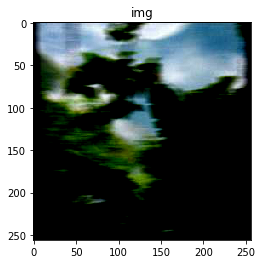

In [0]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,1,1),plt.imshow(img_blur[0]),plt.title('img')

In [0]:
from keras.layers import Input, Dense, Flatten, Dropout , concatenate ,MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import  Conv2D
from keras.models import Model
from keras.layers.merge import Average
from keras.layers.core import Lambda
from keras.optimizers import Adam

image_shape = (256, 256, 3)
channel_rate = 64
patch_shape = (channel_rate, channel_rate, 3)

Using TensorFlow backend.


In [0]:
def build_Dense(inputs,has_dilation='no'):
  
    x = Activation("relu")(inputs)
    x = Conv2D(4*channel_rate, kernel_size=1, padding="same")(x)
    
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)  
    if has_dilation=='no':
      x = Conv2D(channel_rate, kernel_size=3, padding="same")(x)
    else:
      x = Conv2D(channel_rate, kernel_size=3, padding="same", dilation_rate=has_dilation)(x)
    x = BatchNormalization(momentum=0.8)(x)
    d = Dropout(rate=0.5)(x)
    
    return d

In [0]:
def build_generator():
  
    inputs = Input(shape=(None, None, 3))
    #Head
    Head = Conv2D(4*channel_rate, kernel_size=3, padding="same")(inputs)
    #Dense
    d1 = build_Dense(Head)
    x = concatenate([Head, d1])
    d2 = build_Dense(x,(1, 1))
    x = concatenate([x, d2])
    d3 = build_Dense(x)
    x = concatenate([x, d3])
    d4 = build_Dense(x,(2, 2))
    x = concatenate([x, d4])
    d5 = build_Dense(x)
    x = concatenate([x, d5])
    d6 = build_Dense(x,(3, 3))
    x = concatenate([x, d6])
    d7 = build_Dense(x)
    x = concatenate([x, d7])
    d8 = build_Dense(x,(2, 2))
    x = concatenate([x, d8])
    d9 = build_Dense(x)
    x = concatenate([x, d9])
    d10 = build_Dense(x,(1, 1))
    #Tail
    x = Activation("relu")(x) 
    x = Conv2D(4*channel_rate, kernel_size=1, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    #Global Skip Connection
    x = concatenate([Head, x])
    x = Conv2D(channel_rate, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    #output
    out = Conv2D(3, kernel_size=3, padding="same", activation='tanh')(x)
    
    model = Model(inputs, out)
    
    return model
    

In [0]:
def build_discriminator():
    inputs = Input(shape=patch_shape)
    x =Conv2D(channel_rate, kernel_size=3, strides=2, padding="same")(inputs)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x =Conv2D(2*channel_rate, kernel_size=3, strides=2, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x =Conv2D(4*channel_rate, kernel_size=3, strides=2, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x =Conv2D(8*channel_rate, kernel_size=3, strides=2, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    #x =Conv2D(4*channel_rate, kernel_size=3, strides=2, padding="same")(x)
    #x = Activation('sigmoid')(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, out)
    
    # discriminator
    inputs = Input(shape=image_shape)

    list_row_idx = [(i * channel_rate, (i + 1) * channel_rate) for i in
                    range(int(image_shape[0] / patch_shape[0]))]
    list_col_idx = [(i * channel_rate, (i + 1) * channel_rate) for i in
                    range(int(image_shape[1] / patch_shape[1]))]

    list_patch = []
    for row_idx in list_row_idx:
        for col_idx in list_col_idx:
            x_patch = Lambda(lambda z: z[:, row_idx[0]:row_idx[1], col_idx[0]:col_idx[1], :])(inputs)
            list_patch.append(x_patch)

    x = [model(patch) for patch in list_patch]
    outputs = Average()(x)
    model = Model(inputs=inputs, outputs=outputs, name='Discriminator')
    
    return model

In [0]:
def generator_and_discriminator(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    output = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=output)
    return model

In [0]:
g = build_generator()
print("-- Generator -- ")
g.summary()
d = build_discriminator()
print("\n\n-- Discriminator -- ")
d.summary()
m = generator_and_discriminator(build_generator(), build_discriminator())
print("\n\n-- generator_and_discriminator -- ")
m.summary()

W0709 18:18:55.913721 140167474952064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 18:18:55.936981 140167474952064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 18:18:55.940773 140167474952064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 18:18:55.979459 140167474952064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0709 18:18:55.980423 1401674749

-- Generator -- 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 2 7168        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 2 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 2 590080      activation_1[0][0]               
____________________________________________________________________________________________

In [0]:
import keras.backend as K
import numpy as np
from keras.applications.vgg16 import VGG16

def generator_loss(y_true, y_pred):
  
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_shape)
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    # let the loss model can't be trained
    loss_model.trainable = False
    # loss_model.summary()
    perceptual_loss = K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))
  
    l1_loss = K.mean(K.abs(y_pred - y_true))
    
    return 145 * perceptual_loss + 170 * l1_loss


def adversarial_loss(y_true, y_pred):
    return -K.log(y_pred)

In [0]:
import glob as gb

import numpy as np
from PIL import Image

def train(batch_size, epoch_num):
    # Note the x(blur) in the second, the y(full) in the first
    y_train, x_train = load_data(data_type='train')

    # GAN
    g = build_generator()
    d = build_discriminator()
    d_on_g = generator_and_discriminator(g, d)

    # compile the models, use default optimizer parameters
    # generator use adversarial loss
    g.compile(optimizer='adam', loss=generator_loss)
    # discriminator use binary cross entropy loss
    d.compile(optimizer='adam', loss='binary_crossentropy')
    # adversarial net use adversarial loss
    d_on_g.compile(optimizer='adam', loss=adversarial_loss)
    
    for epoch in range(epoch_num):
        print('epoch: ', epoch + 1, '/', epoch_num)
        print('batches: ', int(x_train.shape[0] / batch_size))

        for index in range(int(x_train.shape[0] / batch_size)):
            # select a batch data
            image_blur_batch = x_train[index * batch_size:(index + 1) * batch_size]
            image_full_batch = y_train[index * batch_size:(index + 1) * batch_size]
            generated_images = g.predict(x=image_blur_batch, batch_size=batch_size)

            # output generated images for each 30 iters
            if (index % 3 == 0) and (index != 0):
                generate_image(image_full_batch, image_blur_batch, generated_images,
                                          '/content/gdrive/My Drive/data (1)/result/interim/', epoch, index)

            # concatenate the full and generated images,
            # the full images at top, the generated images at bottom
            x = np.concatenate((image_full_batch, generated_images))

            # generate labels for the full and generated images
            y = [1] * batch_size + [0] * batch_size

            # train discriminator
            d_loss = d.train_on_batch(x, y)
            print('batch %d d_loss : %f' % (index + 1, d_loss))

            # let discriminator can't be trained
            d.trainable = False

            # train adversarial net
            d_on_g_loss = d_on_g.train_on_batch(image_blur_batch, [1] * batch_size)
            print('batch %d d_on_g_loss : %f' % (index + 1, d_on_g_loss))

            # train generator
            g_loss = g.train_on_batch(image_blur_batch, image_full_batch)
            print('batch %d g_loss : %f' % (index + 1, g_loss))

            # let discriminator can be trained
            d.trainable = True

            # output weights for generator and discriminator each 30 iters
            if (index % 3 == 0) and (index != 0):
                g.save_weights('/content/gdrive/My Drive/data (1)/weight/generator_weights.h5', True)
                d.save_weights('/content/gdrive/My Drive/data (1)/weight/discriminator_weights.h5', True)




if __name__ == '__main__':
    train(batch_size=1, epoch_num=10)
    


W0709 18:19:35.042618 140167474952064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0709 18:19:35.088008 140167474952064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0709 18:19:45.544918 140167474952064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch:  1 / 10
batches:  604
batch 1 d_loss : 0.618623


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


batch 1 d_on_g_loss : 0.226270
batch 1 g_loss : 31378.662109
batch 2 d_loss : 1.762499


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


batch 2 d_on_g_loss : 0.057541
batch 2 g_loss : 310938.343750
batch 3 d_loss : 1.519974
batch 3 d_on_g_loss : 0.424941
batch 3 g_loss : 27819.009766
batch 4 d_loss : 1.354690
batch 4 d_on_g_loss : 0.071598
batch 4 g_loss : 88940.523438
batch 5 d_loss : 0.129449
batch 5 d_on_g_loss : 0.140305
batch 5 g_loss : 43991.921875
batch 6 d_loss : 0.174672
batch 6 d_on_g_loss : 0.000430
batch 6 g_loss : 44462.933594
batch 7 d_loss : 0.179086
batch 7 d_on_g_loss : 1.943064
batch 7 g_loss : 31436.488281
batch 8 d_loss : 0.061648
batch 8 d_on_g_loss : 0.000014
batch 8 g_loss : 16914.064453
batch 9 d_loss : 0.483864
batch 9 d_on_g_loss : 0.002967
batch 9 g_loss : 22604.884766
batch 10 d_loss : 0.422940
batch 10 d_on_g_loss : 2.994256
batch 10 g_loss : 72252.804688
batch 11 d_loss : 0.115126
batch 11 d_on_g_loss : 0.000007
batch 11 g_loss : 63472.855469
batch 12 d_loss : 0.039094
batch 12 d_on_g_loss : 0.000042
batch 12 g_loss : 35210.164062
batch 13 d_loss : 0.001334
batch 13 d_on_g_loss : 0.000376


KeyboardInterrupt: ignored

In [0]:

def test(batch_size):
    # Note the x(blur) in the second, the y(full) in the first
    y_test, x_test = load_data(data_type='test')
    g = build_generator()
    g.load_weights('/content/gdrive/My Drive/data (1)/weight/generator_weights.h5')
    generated_images = g.predict(x=x_test, batch_size=batch_size)
    generate_image(y_test, x_test, generated_images, '/content/gdrive/My Drive/data (1)/result/finally/')


def test_pictures(batch_size):
    data_path = '/content/gdrive/My Drive/data (1)/test/*.jpeg'
    images_path = gb.glob(data_path)
    data_blur = []
    for image_path in images_path:
        image_blur = Image.open(image_path)
        data_blur.append(np.array(image_blur))

    data_blur = np.array(data_blur).astype(np.float32)
    data_blur = normalization(data_blur)

    g = build_generator()
    g.load_weights('/content/gdrive/My Drive/data (1)/weight/generator_weights.h5')
    generated_images = g.predict(x=data_blur, batch_size=batch_size)
    generated = generated_images * 127.5 + 127.5
    for i in range(generated.shape[0]):
        image_generated = generated[i, :, :, :]
        Image.fromarray(image_generated.astype(np.uint8)).save('/content/gdrive/My Drive/data (1)/result/test/' + str(i) + '.png')
        

        
        
test(1)
test_pictures(1)

ResourceExhaustedError: ignored